::: {.hidden}
$$
\newcommand{\R}{\mathbb{R}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\mX}{\mathbf{X}}
\newcommand{\vw}{\mathbf{w}}
\newcommand{\bracket}[1]{\langle #1 \rangle}
\newcommand{\paren}[1]{\left( #1 \right)}
\newcommand{\one}[1]{\mathbb{1}\left[ #1 \right]}
\newcommand{\cL}{\mathcal{L}}
\newcommand{\cD}{\mathcal{D}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\prob}[1]{\mathbb{P}\left[#1\right]}
\newcommand{\E}{\mathbb{E}}

\usepackage{amsmath}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

:::

In this lecture, we are going to develop our core theoretical framework for supervised prediction. *Supervised* means that we are trying to predict something for which there is, or could be, a "ground-truth answer." Some examples of supervised tasks are: 

- Predicting whether a person convicted of a crime is likely to commit another crime within the next few years. 
- Predicting whether a landlord is likely to raise rent on a property. 
- Predicting whether a user is likely to click on an ad. 

In each of these cases, you could find out whether your prediction was right or wrong just by waiting and checking. Did you predict that a person is likely to commit a crime within the next few years? Wait two years and find out whether you were right.  

[The line between supervised and unsupervised tasks can be porous. For example, large language models are generally trained using "next word prediction," in which the task is to predict which word comes next in a sentence. This is a supervised task! But they are then used for the unsupervised purpose of generating realistic synthetic text.]{.aside}

In contrast, *unsupervised* algorithms generate output for which there is no firm right answer. Unsupervised machine learning tasks aim to do things like "find patterns" or "generate realistic examples." Large language models (LLMs) like ChatGPT are perhaps the most prominent examples of unsupervised models these days. 

Big picture, the goal of supervised learning is to find a function that takes in some *features* and uses them to make a *prediction* that is *usually right*. Heuristically, we're looking for a function $f$ that accepts some features $x_1,\ldots,x_p$ and gives a prediction $\hat{y}$ that is "close" to the real answer $y$: 

$$
f(x_1,\ldots,x_p) = \hat{y} \approx y\;. 
$$

What does "$\approx$" actually mean in this context? Briefly, we mean that $\hat{y}$ is *usually* "close" to $y$ *when measured in a certain way*. 

The goal of supervised learning is to "train" a "model" that will make "good" "predictions" on "data." We need to cash out each of these terms.

# The Data

Let's start with "data." In a supervised learning problem, our goal is to predict an outcome, which we'll call $y$, on the basis of some 

::: {.callout-note}

::: {#def-data-set}

## Data For Supervised Learning 

In a supervised learning task, the *data* is a pair $(\mX, \vy)$ where 

- $\mX \in \R^{n\times p}$ is the *feature matrix*. There are $n$ distinct observations, encoded as rows. Each of the $p$ columns corresponds to a *feature*: something about each observation that we can measure or infer. Each observation is written $\vx_1, \vx_2,\ldots$. 
$$
\mX = \left[\begin{matrix} & - & \vx_1 & - \\ 
& - & \vx_2 & - \\ 
& \vdots & \vdots & \vdots \\ 
& - & \vx_{n} & - \end{matrix}\right]
$$
- $\vy \in \R^{n}$ is the *target vector*. The target vector gives a label, value, or outcome for each observation. 

:::
:::

## Data Generating Distributions

Intuitively, a data generating distribution is an expression of our expectations of what the world looks like. For example, let's suppose we are trying to predict whether someone enjoys skiing. So, we do a survey in which we ask two questions: 

- On a scale from 1 to 10, how much do you enjoy being outdoors in cold weather? 
- Do you enjoy skiing? (yes/no)

Here, we have a single feature $x\in [10]$ and a binary outcome $y \in \{0,1\}$.  We might imagine that when $x$ is larger, it is more likely for $y$ to be equal to 1. Here's a probabilistic model that expresses this idea: 

$$
\begin{align}
    \prob{X = x} &= 1/10 \quad \forall x \in [10] \\ 
    \prob{Y = 1 | X} &= \frac{x}{11}\;.
\end{align}
$$


This probabilistic model is an example of a *data generating distribution*. The reason it's called this is that you could "generate" a data point from it: first pick a random value of $x$ uniformly between 1 and 10. Then, to generate $y$, flip a weighted coin with probability of heads equal to $x/11$. 



Here's some "data" sampled from this probabilistic model: 


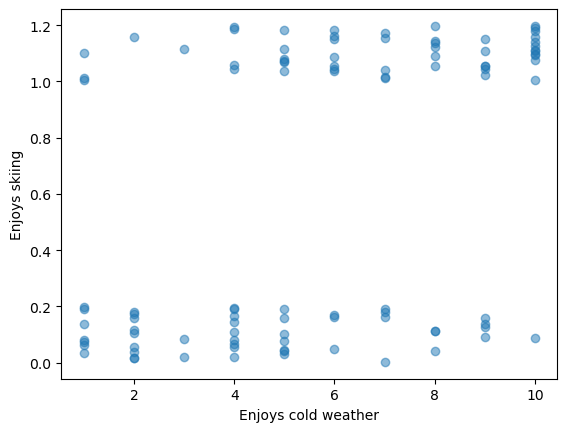

In [24]:
#| fig-cap: Data sampled from the probabilistic model of enjoyment of skiing based on enjoyment of cold weather. The vertical axis has been jittered so for legibility. 
#| label: fig-synthetic-data

import numpy as np 
from matplotlib import pyplot as plt 

n = 100
x = np.random.randint(1, 11, n)
y = np.random.rand(n) < x/11


f = plt.scatter(x, y + 0.2*np.random.rand(n) - 0.1, alpha = 0.5)
l = plt.xlabel("Enjoys cold weather") 
l = plt.ylabel("Enjoys skiing")

::: {.callout-note} 
::: {#def-data-generating-distribution}

## Data Generating Distribution

An *observation generating distribution* is a probability distribution describing the likelihood of a single observation $(\vx, y)$. We'll usually call this distribution $p_\cD$, so that the likelihood of realizing the pair $(\vx, y)$ is $p_\cD(\vx, y)$. 

A *data generating distribution* is a probability distribution describing the likelihood of a feature matrix-target vector pair $(\mX, \vy)$ with $n$ observations. In this class we'll always assume that the observations are independent and identically distributed (i.i.d.) according to $p_\cD$, and so the data generating distribution can be written  

$$
P_\cD(\mX, \vy) = \prod_{i = 1}^n p_\cD(\vx_i, y_i)\;.
$$

:::
:::


If we knew the data distribution, then it would be easy to make good predictions. In the supervised learning framework, we don't usually assume that we *know* the probability model, but we do usually assume that there *is* one. Our job is to help our models find the patterns encoded in the data generating distribution. 

Recall that in the case of the perceptron, we assumed that we were dealing with *linearly separable* data like the ones shown below: 

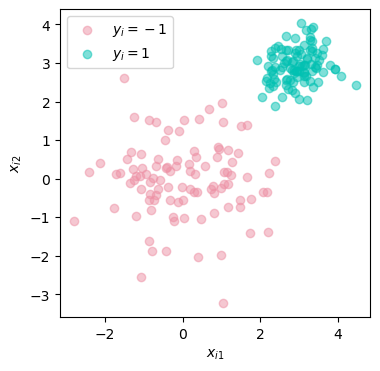

In [25]:
#| fig-cap: "200 data points in the 2d plane, each of which has one of two labels."
#| fig-cap-location: margin
#| label: fig-scatter

import numpy as np
from matplotlib import pyplot as plt
from hidden.perceptron import perceptron_update, draw_line

np.random.seed(123)

plt.rcParams["figure.figsize"] = (4, 4)

X1 = np.random.normal(0, 1, 100)
X2 = np.random.normal(0, 1, 100)

X3 = np.random.normal(0, 1, 100)*.5+3
X4 = np.random.normal(0, 1, 100)*.5+3

fig, ax = plt.subplots(1, 1)

def plot_scatter(X1, X2, X3, X4, ax, legend = True):
    
    s = ax.scatter(X1, X2, color = "#ED90A4", alpha = 0.5, label = r"$y_i = -1$")
    s = ax.scatter(X3, X4, color = "#00C1B2", alpha = 0.5, label = r"$y_i = 1$")
    l = ax.set(xlabel = r"$x_{i1}$")
    l = ax.set(ylabel = "$x_{i2}$")
    if legend:
        l = ax.legend()
    
plot_scatter(X1, X2, X3, X4, ax)

::: {.callout-warning} 

## Activity 1

Can you write down some ideas for an observation generating distribution that would generate data that looks like this? Feel free to use a weight vector $\vw$, a bias $b$, and anything else you might need. 

:::

# Models and Algorithms

Now let's move on to formally define supervised machine learning models and algorithms. 

::: {.callout-note} 
::: {#def-model}
## Machine Learning Models

A *machine learning model* is a function $f:\R^p\rightarrow \R$ whose domain is a space of possible feature vectors. 
:::
:::

::: {.callout-note} 
::: {#def-families}
## Model Families

A *model family* $\mathcal{M}$ is a (possibly infinite) set of models. Each element of $\mathcal{M}$ is indexed by a finite *parameter vector* which we generally call $\boldsymbol{\theta}$. 
:::
:::

::: {.callout-note} 
::: {#def-families}
## Model Families

A *machine learning algorithm* is a model family $\mathcal{M}$ and an algorithm for choosing a single model $f_{\boldsymbol{\theta}} \in \mathcal{M}$ based on an input pair $(\mX, \vy)$. The algorithm is often called the *training algorithm*. 

:::
:::

::: {.callout-warning} 

## Activity 1

Recall the perceptron algorithm. Identify the parameters $\boldsymbol{\theta}$, the model family $\mathcal{M}$, and the training algorithm. 

:::


# Loss and Risk

How do we construct training algorithms that let us pick out a single model from a family $\mathcal{M}$ of possible models? For this we need to start getting more specific about what it means for a model to "fit the data." For this, we need to ask: 

> What does it mean for a predicted outcome $\hat{y}$ to be "close" to an observed outcome $y$? 

Recall that [when we studied the perceptron](perceptron.ipynb), we made a prediction in two steps: 

1. We computed a number $\hat{y}_i = \bracket{\tilde{\vw}, \tilde{\vx}_i}$. 
2. We viewed this prediction as *accurate* if the sign of $\hat{y}_i$ matched the sign of $y_i$, and inaccurate otherwise. [Recall that in the perceptron, we considered outcome labels $y \in \{0,1\}$.]{.aside} Accurate predictions received a score of 1, while inaccurate predictions received a score of 0. The score of a prediction could therefore be written $\one{\hat{y}_i y_i > 0}$. The *loss* of a prediction was $\ell(\hat{y}, y) = 1 - \one{\hat{y}_i y_i > 0}$. The loss of an entire set of predictions was the mean loss on the entire data set: 
$$
\begin{align}
\cL(\hat{\vy}, \vy) &= \frac{1}{n}\sum_{i = 1}^n \ell(\hat{y}_i, y_i) \\ 
&= \frac{1}{n}\sum_{i = 1}^n \left(1 - \one{\hat{y}_i y_i > 0}\right)\;. 
\end{align}
$$

We aimed for the perceptron to find a weight vector so that the prediction vector $\hat{\vy}$ would produce small loss. Why did we do this? We hope that finding a model with small loss will lead to *generalization*: the ability to make predictions on data that we haven't seen yet. We can express the model's performance on *unseen* data using the data generating distribution: 

::: {.callout-note} 

::: {#def-risk}

## Risk 

The *risk* of a model $f:\R^n \rightarrow \R$ is the expected loss of $\hat{y} = f(\vx)$ under the data generating distribution $P_\cD$. We can write the risk as 
$$
R(f) = \E_{\cD}\left[\cL(f(\vx), y)\right]\;,
$$ {#eq-risk}
:::

where $\E_{\cD}$ means "expectation with respect to the data generating distribution." 

:::

If the data generating distribution is discrete, then we can write @eq-risk as 

$$
R(f) = \sum_{\vx \in \mathcal{X}, y \in \mathcal{Y}} p_{\cD}(\vx, y) \ell(f(\vx), y)\;, 
$$

where $\mathcal{X}$ and $\mathcal{Y}$ are the sets of possible feature vectors and labels, respectively. If the data generating distribution is continuous, then the risk instead needs to be expressed as an integral: 

$$
R(f) = \int_{\mathcal{X}, \mathcal{Y}} p_{\cD}(\vx, y) \ell(f(\vx), y) d\vx \; dy\;.  
$$

We're now able to say what it means for a model to make good predictions: 

> A "good" predictive model is a model that achieves low risk.  

### Empirical Risk 

Actually computing the risk of a model via @eq-risk requires that we both choose the loss function $\cL$ and that we know the data generating distribution $p_\cD$. [There are also questions to ask about how to choose the loss function, but we'll get there later.]{.aside} There's a problem with this though: we only ever observe data, not the data generating distribution. So, we can't actually compute the risk -- we can only *estimate* it. We typically estimate the risk using the law of large numbers, which says that if $Z$ is a random variable and $Z_1,\ldots,Z_n,\ldots$ are all i.i.d. copies of $Z$, then the empirical mean $\frac{1}{n} \sum_{i = 1}^n Z_i$ is very likely to be close to the theoretical expectation $\E[Z]$ when $n$ is large. This motivates us to consider the empirical risk. 

::: {.callout-note} 
::: {#def-empirical-risk}

## Empirical Risk

The *empirical risk* of a model $f$ on a data set $(\mX, \vy)$ is 

$$
\hat{R}(f) = \frac{1}{n} \sum_{i = 1}^n \ell(f(\vx_i), y_i)\;.
$$ {#eq-empirical-risk}

:::
:::

Inspecting @def-empirical-risk, we can see that computing the empirical risk doesn't require the data distribution at all -- just the actual data! This is helpful because the data is the thing we have access to, not the generating distribution. It also doesn't hurt that the sum over all possible values of the feature vector and data label has been replaced with a sum over data points, which typically contains many fewer terms. Much faster computation! 

Of course, there's a cost: a model that achieves low *empirical* risk may not actually have low (real) risk. If we have "enough" data, the law of large numbers tells us that these should be pretty close. What "enough" means, and what to do if you don't have it, is a topic that we'll come back to throughout the course. 

## Empirical Risk Minimization

We are now prepared to formulate a fundamental paradigm for prediction problems in machine learning. 

::: {.callout-note} 

::: {#def-empirical-risk-minimization}

## Empirical Risk Minimization

An *empirical risk minimization problem* involves: 

- A choice of model family $\mathcal{M} = \{f_{\boldsymbol{\theta}}\}$.
- A choice of loss function $\ell: \R \times R \rightarrow \R$.    
- A data set $(\mX, \vy)$. 

The empirical risk problem is then to find the element of $f$, usually expressed via the parameters $\boldsymbol{\theta}$, that minimize the empirical risk: 

$$
\begin{align} 
\hat{\boldsymbol{\theta}} &= \argmin_{\boldsymbol{\theta}} \; \hat{R}(f_\boldsymbol{\theta})  \\ 
&= \argmin_{\boldsymbol{\theta}} \; \frac{1}{n} \sum_{i = 1}^n \ell(f_\boldsymbol{\theta}(\vx_i), y_i)\;.
\end{align}
$$

:::
:::